In [3]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [4]:
import warnings
warnings.filterwarnings('ignore')


In [5]:
import scipy
from scipy import stats
from sklearn.preprocessing import StandardScaler

In [6]:
#Rob: toggle flags
apply_standardization = True
apply_transform = False

## Load and Concatenate

In [7]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [8]:
train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [9]:
train.shape

(1460, 81)

In [10]:
test.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


In [11]:
test.shape

(1459, 80)

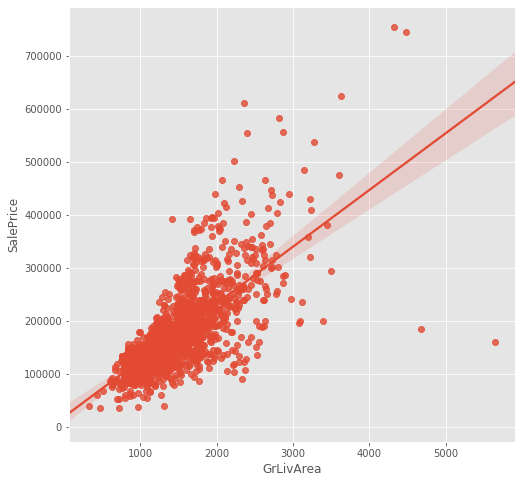

In [12]:
# Very first visual check -- SalePrice ~ GrLivArea
plt.figure(figsize=(8,8))
sns.regplot(x=train.GrLivArea, y=train.SalePrice, data=train)

In [13]:
# remove outliers with GrLivArea > 4_000 sqf
#Rob: revisit these 4 outliers once model pipeline is complete
train = train[train.GrLivArea < 4_000]

In [14]:
# TARGET VARIABLE
SalePrice = train.pop('SalePrice')

In [15]:
df = pd.concat([train, test], axis=0)

In [16]:
df.shape

(2915, 80)

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2915.0,1460.734820,843.045773,1.0,731.5,1462.0,2190.50,2919.0
MSSubClass,2915.0,57.133791,42.546667,20.0,20.0,50.0,70.00,190.0
LotFrontage,2429.0,69.128860,22.715440,21.0,59.0,68.0,80.00,313.0
LotArea,2915.0,10133.648714,7806.198515,1300.0,7474.0,9450.0,11554.50,215245.0
OverallQual,2915.0,6.083705,1.403444,1.0,5.0,6.0,7.00,10.0
OverallCond,2915.0,5.565009,1.113718,1.0,5.0,5.0,6.00,9.0
YearBuilt,2915.0,1971.271698,30.290998,1872.0,1953.0,1973.0,2001.00,2010.0
YearRemodAdd,2915.0,1984.240480,20.897341,1950.0,1965.0,1993.0,2004.00,2010.0
MasVnrArea,2892.0,101.399378,177.452915,0.0,0.0,0.0,164.00,1600.0
BsmtFinSF1,2914.0,438.098147,442.872077,0.0,0.0,368.0,732.00,4010.0


## Divide by data type

In [18]:
# drop Id
df.drop(['Id'], axis=1, inplace=True)

In [19]:
#Rob: changed to list(...columns)
cat_features = list(train.select_dtypes(include=['object']).columns)
print(f'Object types:  {len(cat_features)}')
print(cat_features)

Object types:  43
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [20]:
#Rob: changed to list(...columns)

num_features = list(train.select_dtypes(include=['int64','float64']).columns)
print(f'Numeric types:  {len(num_features)}')
print(num_features)

Numeric types:  37
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [21]:
# Some numeric features are categorical and ordinal, 
# leave the numerical values (potentially intact) but reclassify to categorical
cat_features += ['OverallQual', 'OverallCond']

# Some numeric features are categorical by nature and NOT ordinal: replace with string
df['MSSubClass'] = df.MSSubClass.apply(lambda x: str(x))
df['MoSold'] = df.MoSold.apply(lambda x: str(x))
df['YrSold'] = df.YrSold.apply(lambda x: str(x))

cat_features += ['MSSubClass', 'MoSold', 'YrSold']

print(f'Object types:  {len(cat_features)}')

Object types:  48


In [22]:
# Remove newly classified categoricals from numeric
num_features = [f for f in num_features if f not in cat_features] 
print(f'Numeric types:  {len(num_features)}')

Numeric types:  32


In [23]:
print(cat_features)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'OverallQual', 'OverallCond', 'MSSubClass', 'MoSold', 'YrSold']


In [24]:
print(num_features)

['Id', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


## Classify Ordinal vs. Nominal

By default, all categorical features are nominal.  The following are classified ordinal:
- levels are clearly ordered (e.g. Functional, LandSlope, LotShape). This is regardless of the feature's correlation with price, e.g. may be completely uncorrelated. 
- if we __suspect__ order, verify by a boxplot Price~Feature (e.g. 'MSSubClass'). Classify as ordinal only if there is visual correlation with sorted levels

In [25]:
cat_ordinal = [  # definitely ordinal
'Street',
'Alley',
'LotShape',
'Utilities',
'LandSlope',
'ExterQual',
'ExterCond',
'BsmtQual',
'BsmtCond',
'BsmtExposure',
'BsmtFinType1',
'BsmtFinType2',
'HeatingQC',
'CentralAir',
'KitchenQual',
'Functional',
'FireplaceQu',
'GarageFinish',
'GarageQual',
'GarageCond',
'PavedDrive',
'PoolQC',
'Fence',    
]
print(f'Definitely ordinal:  {len(cat_ordinal)}')

Definitely ordinal:  23


In [26]:
cat_ordinal_candidates = [ # potentially ordinal
'MSSubClass',
'LandContour',
'LotConfig',
'BldgType',    
'HouseStyle',    
'Foundation',
'Electrical',
'SaleType',
'SaleCondition',
]
print(f'Potentially ordinal:  {len(cat_ordinal_candidates)}')

Potentially ordinal:  9


In [27]:
cat_nominal = [f for f in cat_features if f not in cat_ordinal and f not in cat_ordinal_candidates] 
print(f'Definitely nominal:  {len(cat_nominal)}')
cat_nominal

Definitely nominal:  16


['MSZoning',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Heating',
 'GarageType',
 'MiscFeature',
 'OverallQual',
 'OverallCond',
 'MoSold',
 'YrSold']

In [28]:
# We care about display order for the candidate ordinals:
#Rob: added VWD to SaleType, removed comma after SaleCondition 
display_order = {
'MSSubClass': ['20', '30', '40', '45', '50', '60', '70', '75', '80', '85', '90', '120', '160', '180', '190'],
'LandContour': ['Lvl','Bnk', 'HLS', 'Low'],
'LotConfig': ['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'],
'BldgType':    ['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs'],
'HouseStyle':  ['1Story', '1.5Unf', '1.5Fin', '2Story', '2.5Unf', '2.5Fin', 'SFoyer', 'SLvl'],    
'Foundation': ['PConc', 'CBlock', 'BrkTil', 'Wood', 'Slab', 'Stone'],
'Electrical': ['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'],
'SaleType': ['WD','CWD','New','COD','Con','ConLw','ConLI','ConLD','Oth','VWD'],
'SaleCondition': ['Normal','Abnorml','AdjLand','Alloca','Family','Partial']
}

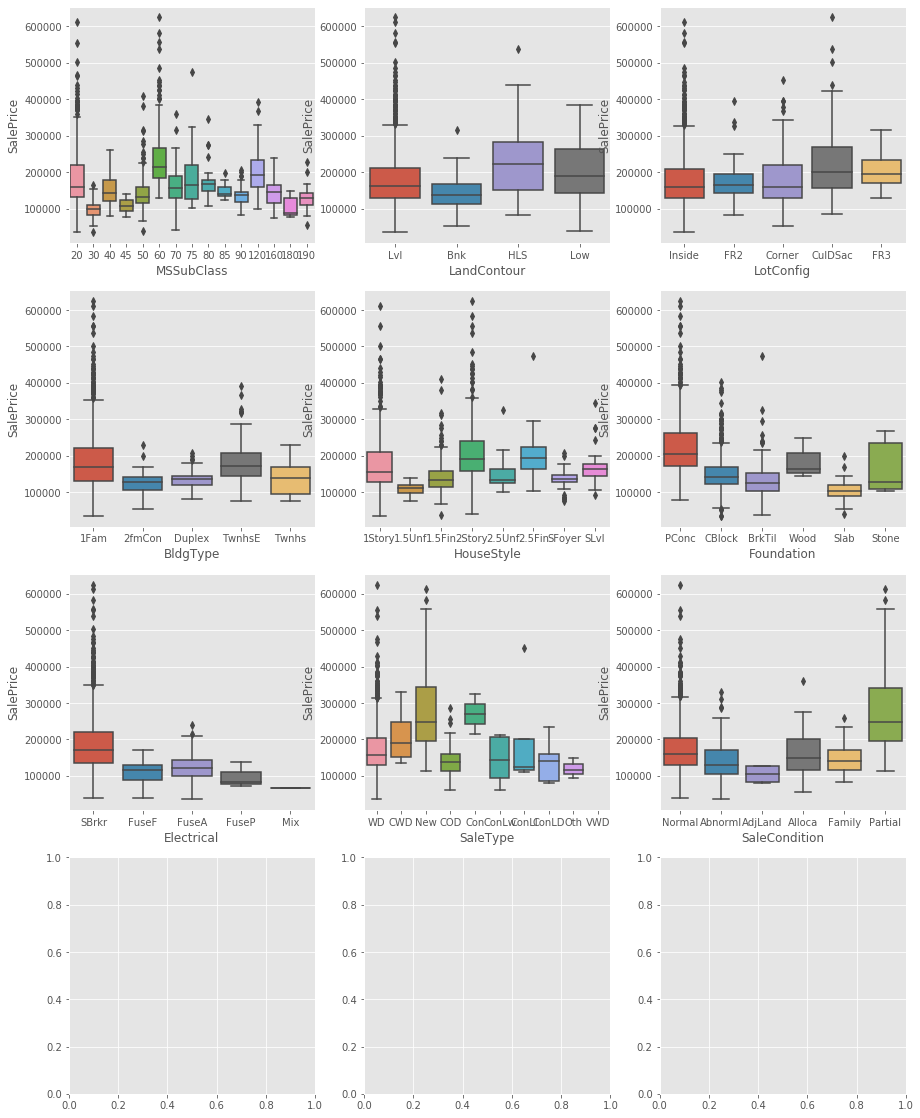

In [29]:
# concatenate Y back for visual purposes
train_processed = pd.concat([df.iloc[:len(SalePrice),:], SalePrice], axis=1)

# plt.subplots(nrows, ncols, figsize=(width, height))
nc  = 3
nr  = 1+len(cat_ordinal_candidates)//nc
f,axes = plt.subplots(nr, nc, figsize=(nc*5, nr*5))

counter = 0
for f in cat_ordinal_candidates:
    sns.boxplot(f, 'SalePrice', data=train_processed, order=display_order[f], 
                ax = axes[counter//nc][counter%nc])
    counter+=1

Conclusion: there is no internal order that would cause a visible correlation with the Price. All candidate features should be classified as nominal. 
#Rob:added for Sam - Fence looks more ordinal than not so adding to ordinals.  DL: added above

In [30]:
cat_nominal = cat_nominal + cat_ordinal_candidates
cat_nominal = list(set(cat_nominal))
cat_ordinal = list(set(cat_ordinal))

print(f'Nominal features:  {len(cat_nominal)}')
print(f'Ordinal features:  {len(cat_ordinal)}')

Nominal features:  25
Ordinal features:  23


Nominal categorical will only be dummified, ordinals remain intact (possibly rescaling)

## Categorical features: Impute nan

Verify each categorical feature to apply the following approach:
- nominal features: replace nan with string 'None' unless has specific meaning
- ordinal features: replace nan with 0 unless nan means something else. Nan typically means the absence of the feature such as 'no garage'.  Later, map the remaining levels to 1,2,..

In [31]:
for f in cat_nominal:
    nans = df[f].isna().sum()
    if nans>0:
        print(f'{nans}   nans in   {f}')

4   nans in   MSZoning
1   nans in   Exterior2nd
1   nans in   SaleType
24   nans in   MasVnrType
1   nans in   Exterior1st
1   nans in   Electrical
157   nans in   GarageType
2810   nans in   MiscFeature


In [32]:
for f in cat_ordinal:
    nans = df[f].isna().sum()
    if nans>0:
        print(f'{nans}   nans in   {f}')

2907   nans in   PoolQC
2   nans in   Functional
2   nans in   Utilities
159   nans in   GarageQual
159   nans in   GarageCond
1420   nans in   FireplaceQu
82   nans in   BsmtExposure
2345   nans in   Fence
81   nans in   BsmtQual
79   nans in   BsmtFinType1
82   nans in   BsmtCond
2717   nans in   Alley
159   nans in   GarageFinish
80   nans in   BsmtFinType2
1   nans in   KitchenQual


Checked all missing columns, the default approach of replacing with 'None' and 0 should work

In [33]:
for f in cat_nominal:
    df[f].fillna('None', inplace=True)

In [34]:
for f in cat_ordinal:
    df[f].fillna(0, inplace=True)

## Map Ordinal to numeric

In [35]:
# NB map the FULL dictionary from the description b/c some labels may appear only in the test set
# still, check unique levels for all ordinals in the train set
{f: list(train[f].unique()) for f in cat_ordinal}

{'PoolQC': [nan, 'Ex', 'Fa', 'Gd'],
 'Functional': ['Typ', 'Min1', 'Maj1', 'Min2', 'Mod', 'Maj2', 'Sev'],
 'Utilities': ['AllPub', 'NoSeWa'],
 'GarageQual': ['TA', 'Fa', 'Gd', nan, 'Ex', 'Po'],
 'GarageCond': ['TA', 'Fa', nan, 'Gd', 'Po', 'Ex'],
 'ExterQual': ['Gd', 'TA', 'Ex', 'Fa'],
 'CentralAir': ['Y', 'N'],
 'ExterCond': ['TA', 'Gd', 'Fa', 'Po', 'Ex'],
 'FireplaceQu': [nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'],
 'BsmtExposure': ['No', 'Gd', 'Mn', 'Av', nan],
 'HeatingQC': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
 'LandSlope': ['Gtl', 'Mod', 'Sev'],
 'Fence': [nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'],
 'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'],
 'BsmtQual': ['Gd', 'TA', 'Ex', nan, 'Fa'],
 'PavedDrive': ['Y', 'N', 'P'],
 'BsmtFinType1': ['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ'],
 'BsmtCond': ['TA', 'Gd', nan, 'Fa', 'Po'],
 'Alley': [nan, 'Grvl', 'Pave'],
 'GarageFinish': ['RFn', 'Unf', 'Fin', nan],
 'BsmtFinType2': ['Unf', 'BLQ', nan, 'ALQ', 'Rec', 'LwQ', 'GLQ'],
 'Street': ['Pave', 'Grvl'],
 'Ki

In [36]:
# Mapping convention: higher levels ~ higher price (NOT always applicable, e.g. LotShape)
# arbitrary convention for the sake of interpretation consistency, should not affect any ML
ordinal_to_numeric = {
    'Street': {'Grvl':1, 'Pave':2},
    'Alley': {'Grvl':1, 'Pave':2},
    'LotShape': {'Reg':1, 'IR1':2, 'IR2':3, 'IR3':4},
    'Utilities': {'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4},
    'LandSlope': {'Gtl':1, 'Mod':2, 'Sev':3}, #Rob: order reversed? shouldn't affect anything but the interpretation
    'Fence':{'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4}, #Rob: added per Sam's analysis

    'ExterQual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'ExterCond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},

    'BsmtQual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'BsmtCond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'BsmtExposure': {'No':1, 'Mn':2, 'Av':3, 'Gd':4},
    'BsmtFinType1': {'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
    'BsmtFinType2': {'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},

    'HeatingQC': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'CentralAir': {'N':0, 'Y':1},
    'KitchenQual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    # bigger step for 'Typical' - #Rob: why use a larger step between Min1 and Typ?
    'Functional': {'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':10},  
    'FireplaceQu': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},

    'GarageFinish': {'Unf':1, 'RFn':2, 'Fin':3},
    'GarageQual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'GarageCond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},

    'PavedDrive': {'N':1, 'P':2, 'Y':3},
    'PoolQC': {'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
}

In [37]:
for f in ordinal_to_numeric:
    df[f].replace(ordinal_to_numeric[f], inplace=True)

In [38]:
# verify 
df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,2,0,1,Lvl,4,Inside,...,0,0,0,0,None,0,2,2008,WD,Normal
1,20,RL,80.0,9600,2,0,1,Lvl,4,FR2,...,0,0,0,0,None,0,5,2007,WD,Normal
2,60,RL,68.0,11250,2,0,2,Lvl,4,Inside,...,0,0,0,0,None,0,9,2008,WD,Normal
3,70,RL,60.0,9550,2,0,2,Lvl,4,Corner,...,0,0,0,0,None,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,2,0,2,Lvl,4,FR2,...,0,0,0,0,None,0,12,2008,WD,Normal


## Adding new Boolean features

In [39]:
# Booleans
df['_Basement'] = df.TotalBsmtSF>0
df['_Garage'] = df.GarageArea>0
df['_Pool'] = df.PoolArea>0
df['_Fence'] = df.Fence!=0  #Rob: Fence is now an ordinal so check for 0 instead of None
# combine 4 types of porches
df['_Porch'] = df.OpenPorchSF+df.EnclosedPorch+df['3SsnPorch']+df.ScreenPorch > 0

#Rob:added
df['_MasVnrArea'] = (df.MasVnrType != 'None')
df['_WoodDeck'] = df.WoodDeckSF > 0
df['_MiscFeature'] = (df.MiscFeature!='None')

In [40]:
# More Booleans
#Rob: revisit the bucketing on YearBuilt if there's time
df['_New'] = df.YearBuilt > 2000  #potentially bucketize the entire range
df['_Old'] = df.YearBuilt < 1920 

df['_Remodeled'] = df.YearRemodAdd != df.YearBuilt
df['_NormalSale'] = df.SaleCondition=='Normal'
df['_AfterWW2'] = (df.YearBuilt >= 1946) #Rob: added per Sam's analysis

In [41]:
#Rob: all the boolean features created thus far
new_boolean = ['_Basement', 
               '_Garage', 
               '_Pool', 
               '_Fence', 
               '_Porch',
               '_MasVnrArea',
               '_WoodDeck', 
               '_MiscFeature',
               '_New',
               '_Old', 
               '_Remodeled', 
               '_NormalSale',
               '_AfterWW2']

In [42]:
# convert to int
for f in new_boolean:
    df[f]=df[f].astype(np.int64)

## Clustering: Categorical

In [43]:
# (optionally add TSNE / UMAP)

In [44]:
all_categorical = cat_nominal + cat_ordinal + new_boolean

In [45]:
chisq_table = np.zeros((len(all_categorical), len(all_categorical)))

for i, f1 in enumerate(all_categorical):
    for j, f2 in enumerate(all_categorical):
        tab = pd.crosstab(df[f1], df[f2])
        chisq_table[i,j] = scipy.stats.chi2_contingency(tab)[1]

sort_order = np.argsort(chisq_table.sum(axis=0))
chisq_table = chisq_table[:,sort_order]
chisq_table = chisq_table[sort_order,:]
heatmap_labels = [all_categorical[i] for i in sort_order]

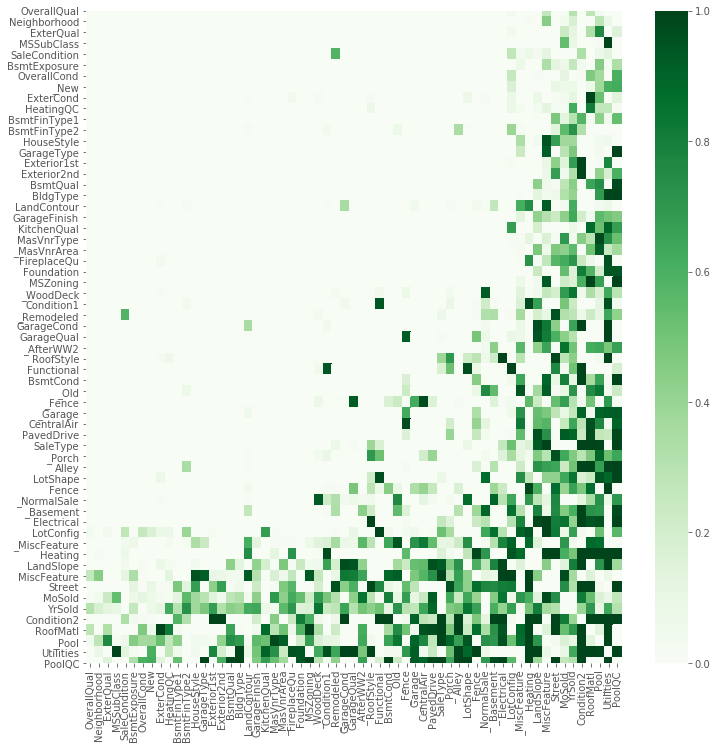

In [46]:
plt.figure(figsize=(12,12))
sns.heatmap(chisq_table, cmap="Greens", xticklabels=heatmap_labels, yticklabels=heatmap_labels)

- The core group of ~10-15 defining characteristics at the top, highly influential (ExterQual, OverallQual, MSSubClass, Neighborhood, New, etc)
- A few categories at the bottom seem to be randomly spread -> candidates for removal

In [47]:
n_tail = 15  #candidates to be removed with n as HP
removal_candidates_0 = heatmap_labels[-n_tail:]
removal_candidates_0

['_Basement',
 'Electrical',
 'LotConfig',
 '_MiscFeature',
 'Heating',
 'LandSlope',
 'MiscFeature',
 'Street',
 'MoSold',
 'YrSold',
 'Condition2',
 'RoofMatl',
 '_Pool',
 'Utilities',
 'PoolQC']

## ANOVA

Verify the clustering intuition with ANOVA LogPrice~Category 

In [48]:
# ANOVA requires that the reponse variables be ~ normal. Log transform the SalePrice.

In [49]:
LogPrice=np.log(SalePrice).rename('LogPrice')

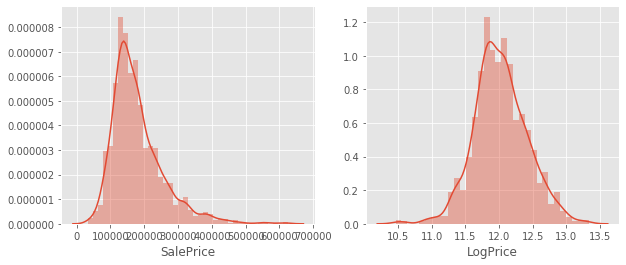

In [50]:
f,axes = plt.subplots(1, 2, figsize=(10, 4))

sns.distplot(SalePrice, ax=axes[0])
sns.distplot(LogPrice, ax=axes[1])

Text(0.5, 1.0, 'After log transform')

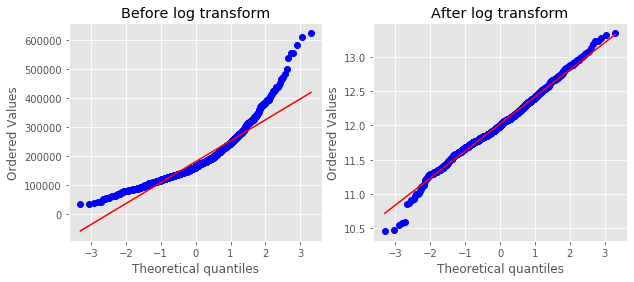

In [51]:
#Rob: put the before and after Q-Q plots side by side for better visuals.
f,axes = plt.subplots(1, 2, figsize=(10, 4))
res1 = stats.probplot(SalePrice, plot=axes[0])
axes[0].set_title("Before log transform")
res2 = stats.probplot(LogPrice, plot=axes[1])
axes[1].set_title("After log transform")

In [52]:
# concatenate Y back for visual purposes
train_processed = pd.concat([df.iloc[:len(LogPrice),:], LogPrice], axis=1)

In [53]:
train_processed.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,_Porch,_MasVnrArea,_WoodDeck,_MiscFeature,_New,_Old,_Remodeled,_NormalSale,_AfterWW2,LogPrice
0,60,RL,65.0,8450,2,0,1,Lvl,4,Inside,...,1,1,0,0,1,0,0,1,1,12.247694
1,20,RL,80.0,9600,2,0,1,Lvl,4,FR2,...,0,0,1,0,0,0,0,1,1,12.109011


In [54]:
# ANOVA F-statistic with its p-value
F_values, p_values = {},{}

for f in all_categorical:
    group_prices = []
    for group in train_processed[f].unique():
        group_prices.append(train_processed[train_processed[f]==group]['LogPrice'].values)

    F_values[f], p_values[f] = scipy.stats.f_oneway(*group_prices)

In [55]:
F_values = {k:v for k,v in sorted(F_values.items(), key=lambda x: x[1])}
p_values = {k:v for k,v in sorted(p_values.items(), key=lambda x: x[1])}

In [56]:
p_values

{'OverallQual': 0.0,
 'Neighborhood': 7.451511247758564e-242,
 'ExterQual': 5.487175661842523e-196,
 'BsmtQual': 2.3173557817592845e-187,
 'KitchenQual': 5.292077079765444e-186,
 'GarageFinish': 2.7129993153636604e-151,
 'GarageType': 3.8754404716470255e-126,
 'MSSubClass': 1.3207872601320131e-114,
 'FireplaceQu': 1.259783529169019e-113,
 'Foundation': 1.4239979430131833e-111,
 '_New': 1.9683225274080212e-87,
 'HeatingQC': 2.058334264452287e-82,
 'BsmtFinType1': 3.1174290570333098e-77,
 'MasVnrType': 3.061545957996824e-67,
 'MSZoning': 2.8287104898669344e-60,
 'Exterior1st': 3.1629861258661e-56,
 '_MasVnrArea': 1.991342016079393e-54,
 'OverallCond': 5.422658470876797e-54,
 'Exterior2nd': 5.062412545054888e-50,
 'GarageCond': 8.378096673084188e-48,
 '_AfterWW2': 1.1217261332133207e-46,
 'BsmtExposure': 1.864979140868811e-46,
 'GarageQual': 2.0672588008711154e-46,
 'CentralAir': 3.7176103148526634e-44,
 'SaleCondition': 4.115462010677253e-44,
 'SaleType': 1.6088300269571204e-37,
 '_Porch


Possible candiates to remove with p-value >0.05: #Rob: changed p-value threshold to 0.05
- '_Pool'
- 'PoolQC'
- 'LandSlope'
- 'MoSold'
- 'YrSold'
- 'Utilities'

## Classify and Visualize

In [57]:
len(all_categorical)

61

In [58]:
#Rob: added the 3 new boolean features
cat_qual = [
 'OverallQual', 
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Heating',
 'GarageType',
 'MiscFeature',  # mainly shed
 
 'Foundation',
 'Electrical',
 'Fence',
 'Utilities',
 
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'CentralAir',
 'KitchenQual',

 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 '_Basement',
 '_Garage',
 '_Pool',
 '_Fence',
 '_Porch',
 '_MasVnrArea',
 '_WoodDeck',
 '_AfterWW2',
 '_MiscFeature'
]

In [59]:
len(cat_qual)

38

In [60]:
# [x for x in all_categorical if x not in elements]

In [61]:
cat_location = [
'MSZoning',
'Neighborhood',
'Condition1',
'Condition2',
]
                
cat_sale = [            
'SaleType',
'SaleCondition',
'_NormalSale',
'MoSold',
'YrSold',
]
    
cat_type = [
'MSSubClass',
'BldgType',
'HouseStyle',
'Functional',
'_Remodeled',
'_Old',
'_New',
]

cat_land = [    
'LotShape',
'LandSlope',
'LandContour',
'LotConfig',
'Street',
'Alley',
'PavedDrive',
]

In [62]:
# verify completeness
assert set(all_categorical)==set(cat_qual+cat_location+cat_sale+cat_type+cat_land)
assert len(all_categorical)==len(cat_qual+cat_location+cat_sale+cat_type+cat_land)


In [63]:
def plot_counts(cat_group, col_wrap=4):
    f = pd.melt(df, value_vars=cat_group)
    g = sns.FacetGrid(f, col='variable', col_wrap=col_wrap, sharex=False, sharey=False)
    g = g.map(sns.countplot, 'value')
    [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
    g.fig.tight_layout()
    plt.show()    

In [64]:
#Rob : disabling the plots of histograms for now as they don't add much information at this point
show_hist = 0 

In [65]:
if show_hist:
    plot_counts(cat_qual)

In [66]:
if show_hist:
    plot_counts(cat_location)

In [67]:
if show_hist:
    plot_counts(cat_sale)

In [68]:
if show_hist:
    plot_counts(cat_type)

In [69]:
if show_hist:
    plot_counts(cat_land)

## Influential features

In [70]:
#Select least p-value features on the F-test. Visualize Boxplots (Price or LogPrice?)

In [71]:
cat_influential = [
# from cat_location
'Neighborhood',
'MSZoning',
# from the cat_sale
'SaleCondition',
'SaleType',    
# from cat_type
'MSSubClass',
'_Old',
'_New',    
# zero from the cat_land
# from cat_qual
'OverallQual', 
'OverallCond',
'KitchenQual',
'FireplaceQu',
'Foundation',
'HeatingQC',
'CentralAir',    
'MasVnrType',
'_Porch',  
    
'Exterior1st',
'Exterior2nd',
'ExterQual',   
    
'GarageFinish',
'GarageType',
'GarageQual',    
'GarageCond',
'_Garage',    
    
'BsmtQual',
'BsmtExposure',    
'BsmtFinType1',    
]
print(f'Inflential features:  {len(cat_influential)}')


Inflential features:  27


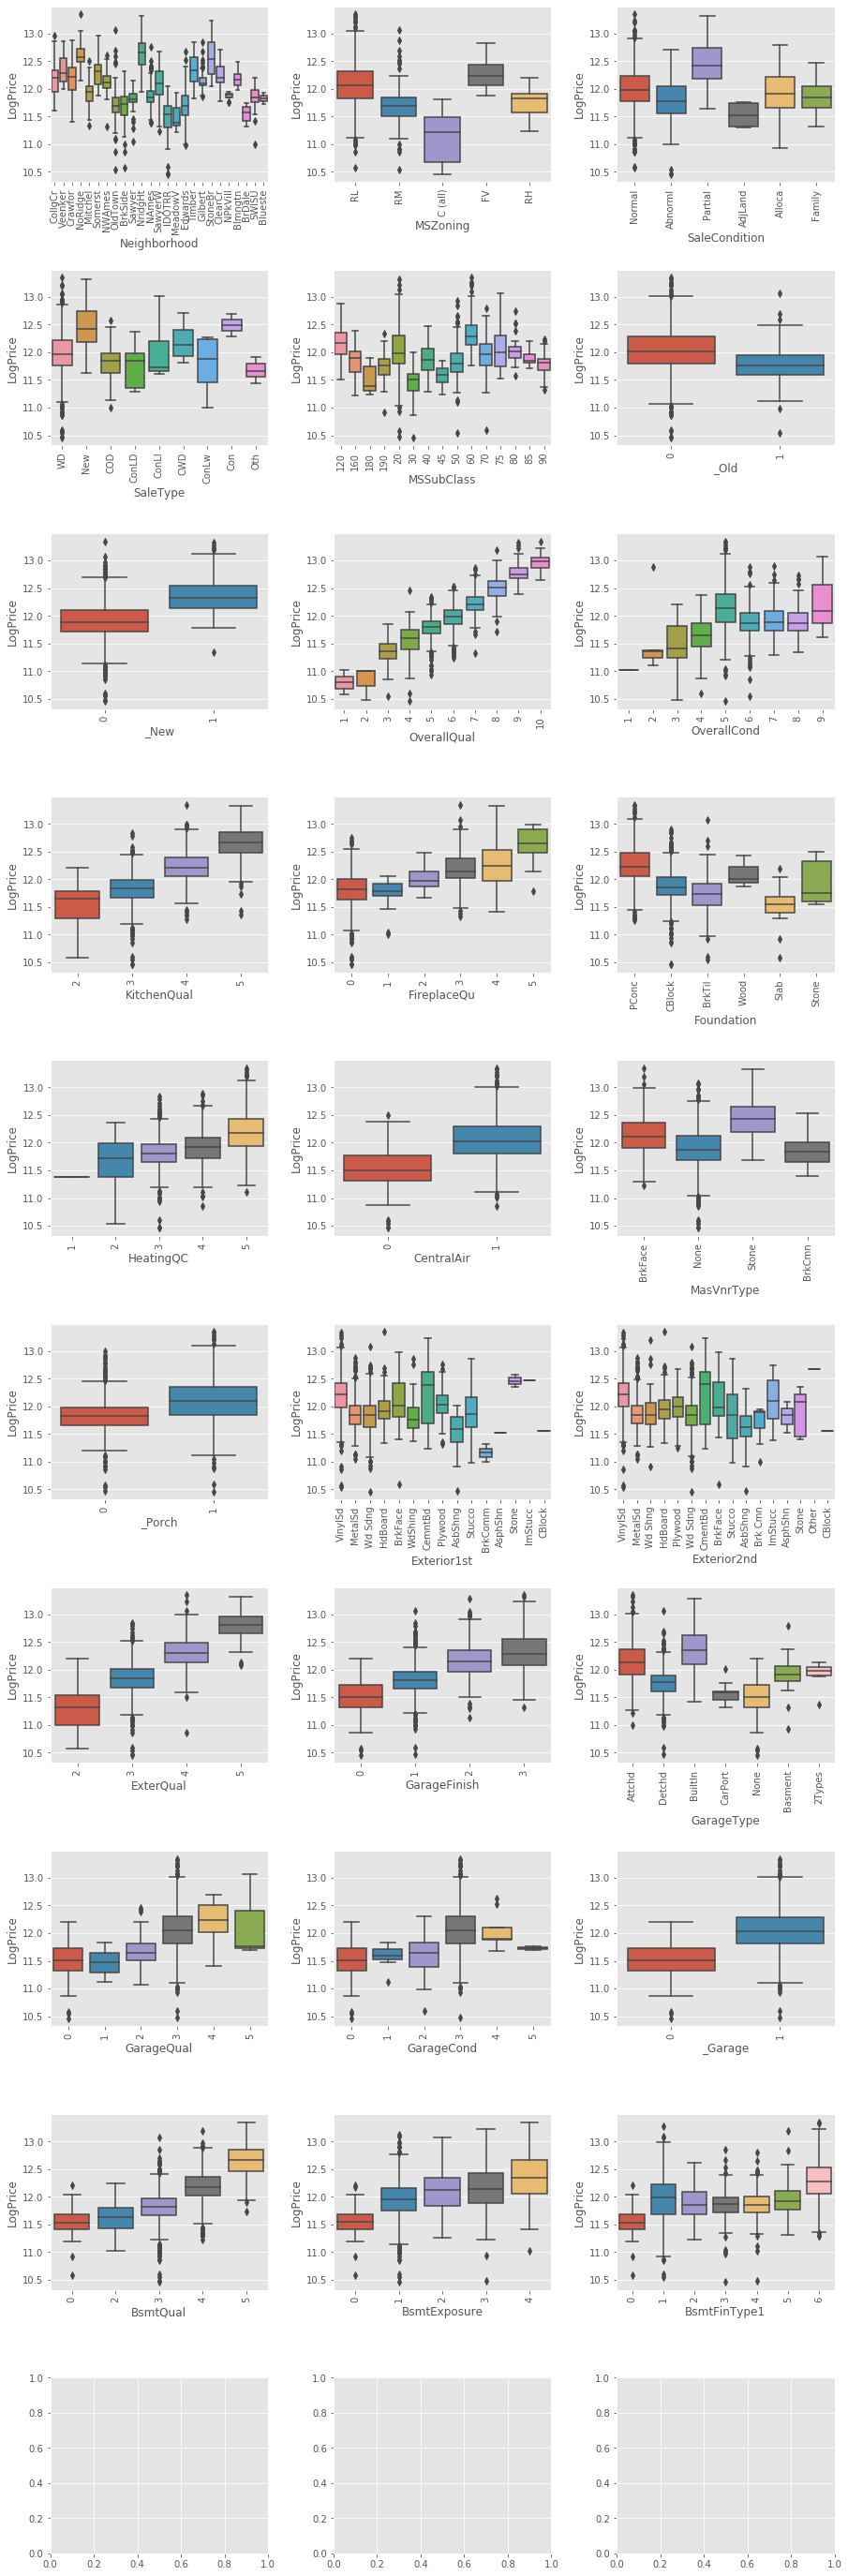

In [72]:
# concatenate Y back for visual purposes
train_processed = pd.concat([df.iloc[:len(LogPrice),:], LogPrice], axis=1)

# plt.subplots(nrows, ncols, figsize=(width, height))
nc  = 3
nr  = 1+len(cat_influential)//nc
f,axes = plt.subplots(nr, nc, figsize=(nc*5, nr*5))
f.subplots_adjust(hspace=.5, wspace=.3,)

counter = 0
for f in cat_influential:
    ax = sns.boxplot(f, 'LogPrice', data=train_processed, ax = axes[counter//nc][counter%nc])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    counter+=1


# NUMERICAL

In [73]:
# divide into 3 groups
len(num_features)

32

In [74]:
num_continous = [
'LotFrontage',
'LotArea',
'MasVnrArea',
'BsmtFinSF1',
'BsmtFinSF2',
'BsmtUnfSF',
'TotalBsmtSF',
'1stFlrSF',
'2ndFlrSF',
'LowQualFinSF',
'GrLivArea',
'GarageArea',
'WoodDeckSF',
'OpenPorchSF',
'EnclosedPorch',
'3SsnPorch',
'ScreenPorch',
'PoolArea',
'MiscVal',
]

num_count = [
'BsmtFullBath',
'BsmtHalfBath',
'FullBath',
'HalfBath',
'BedroomAbvGr',
'KitchenAbvGr',
'TotRmsAbvGrd',
'Fireplaces',
'GarageCars',      
]

num_buckets = [
'YearBuilt',
'YearRemodAdd',
'GarageYrBlt',
]


In [75]:
len(num_continous) + len(num_buckets) + len(num_count)

31

In [76]:
df[num_continous].shape

(2915, 19)

In [77]:
df[num_continous].isnull().sum(axis=0)

LotFrontage      486
LotArea            0
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
GarageArea         1
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
dtype: int64

## Impute missing values

In [78]:
#Rob:
#impute missing values using KNN -- use all features in training set impute missing values for LotFrontage & MasVnr

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors= round(np.sqrt(train[num_continous].shape[0])))

imputer.fit(train['LotFrontage'][:,np.newaxis])
df['LotFrontage'] = imputer.transform(df['LotFrontage'][:,np.newaxis])

imputer.fit(train['MasVnrArea'][:,np.newaxis])
df['MasVnrArea'] = imputer.transform(df['MasVnrArea'][:,np.newaxis])


ImportError: cannot import name 'KNNImputer' from 'sklearn.impute' (/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/impute/__init__.py)

In [79]:
# sum(df.isnull().sum(axis=0))
for f in df.columns:
    nans = df[f].isna().sum()
    if nans>0:
        print(f'{nans}   nans in   {f}')

486   nans in   LotFrontage
23   nans in   MasVnrArea
1   nans in   BsmtFinSF1
1   nans in   BsmtFinSF2
1   nans in   BsmtUnfSF
1   nans in   TotalBsmtSF
2   nans in   BsmtFullBath
2   nans in   BsmtHalfBath
159   nans in   GarageYrBlt
1   nans in   GarageCars
1   nans in   GarageArea


In [80]:
# Explore GarageYrBlt
df[df.GarageYrBlt.isna() & df._Garage==1]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,_Fence,_Porch,_MasVnrArea,_WoodDeck,_MiscFeature,_New,_Old,_Remodeled,_NormalSale,_AfterWW2
666,60,RM,57.0,8094,2,1,1,Lvl,4,Inside,...,1,1,0,1,1,0,1,1,1,0


In [81]:
# replace all with zeros
for f in df.columns:
    df[f].fillna(0, inplace=True)                

In [82]:
#Rob: making the merge easier by creating the df train
train = pd.concat([df.iloc[:len(LogPrice),:], LogPrice], axis=1)

## Numerical features: Correlations & transformations

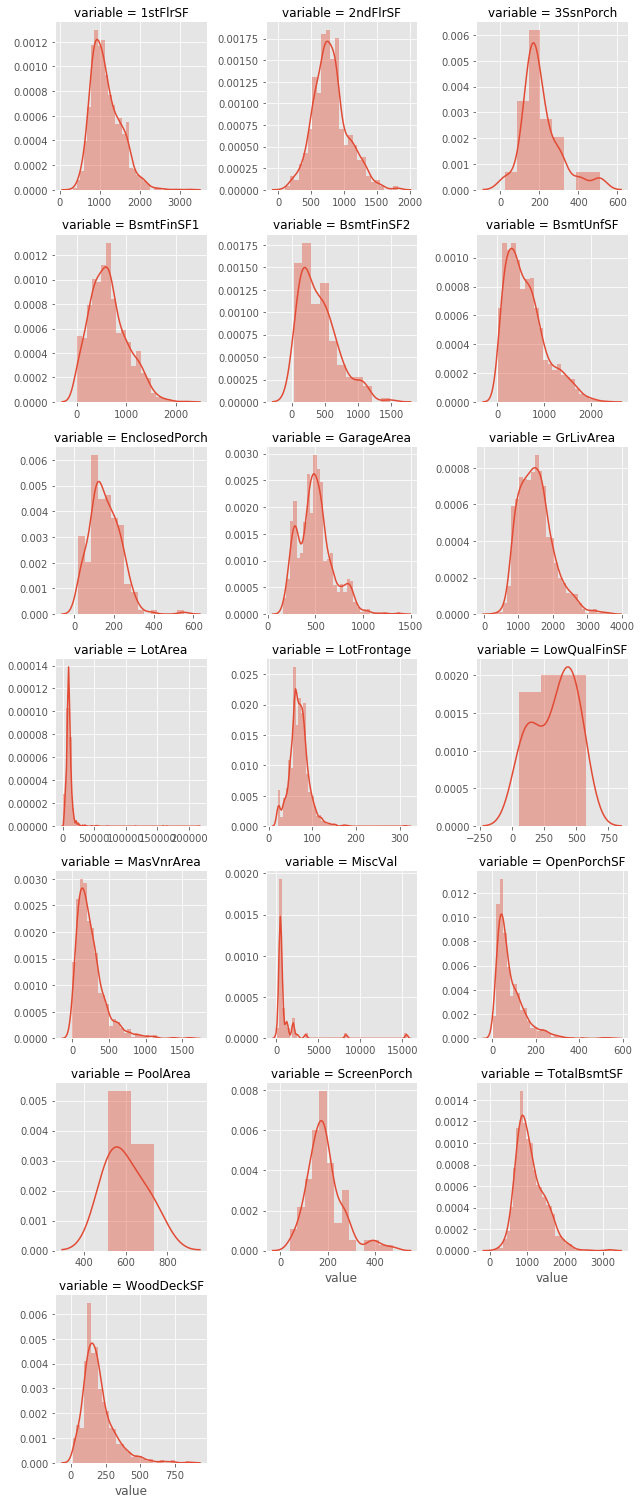

In [83]:
#density plots of original numerica features
f = pd.melt(train[num_continous][train[num_continous]>0], value_vars=sorted(num_continous))
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

pretty much every numerical feature exhibits right skewness - these are good candidates for log transformation

In [84]:
##transform all numerical values
train_transformed = train[num_continous].copy()

for f in num_continous:
    train_transformed.loc[:,f] = np.log1p(train[f])

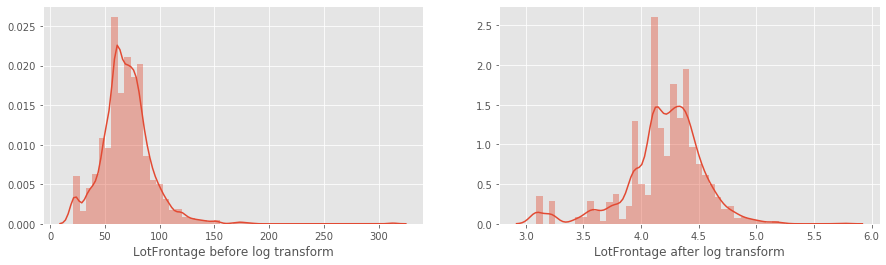

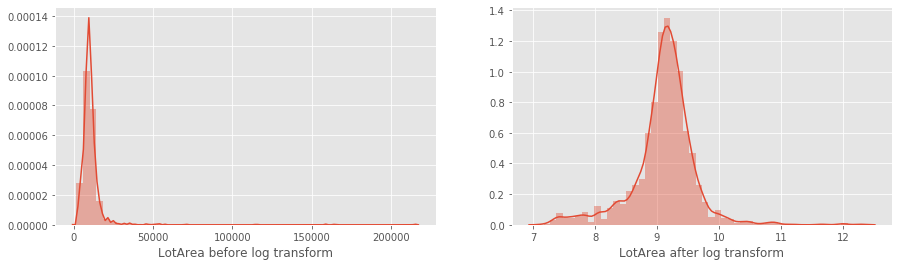

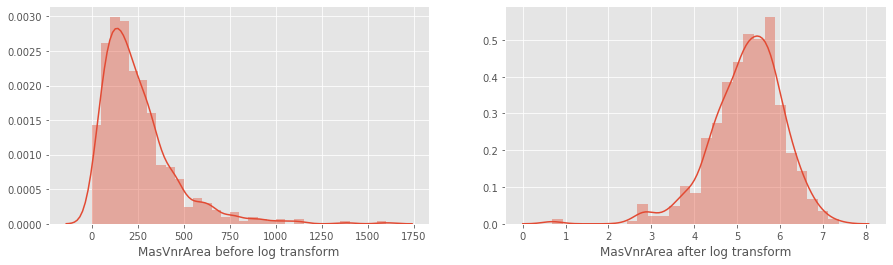

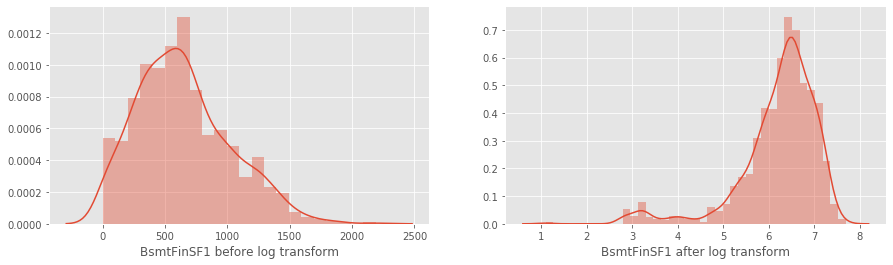

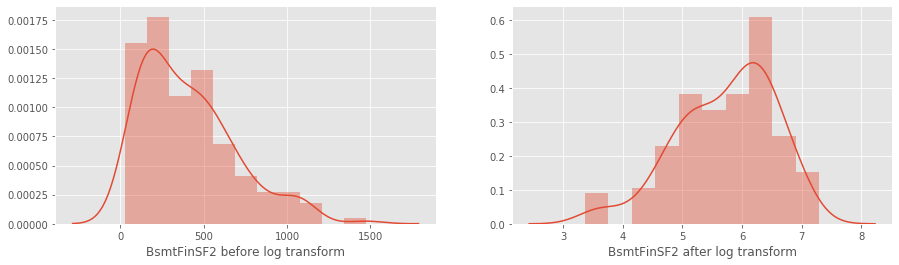

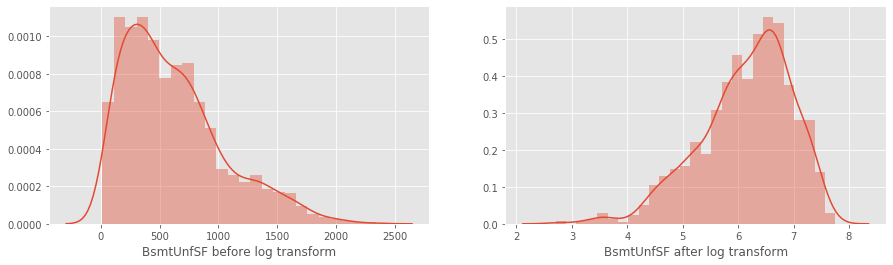

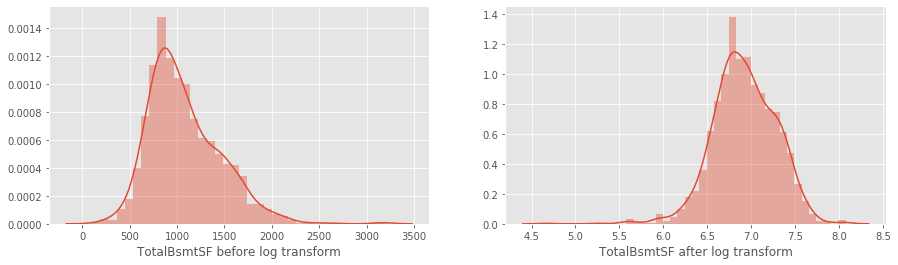

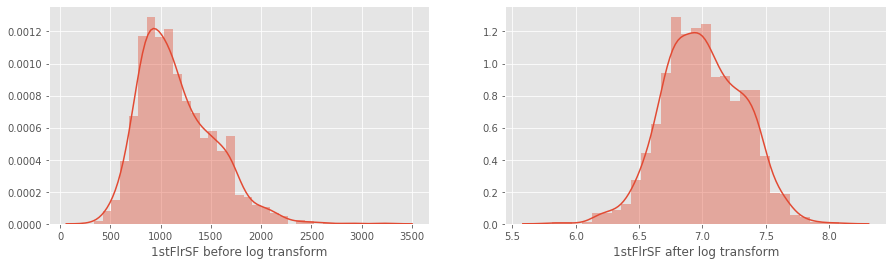

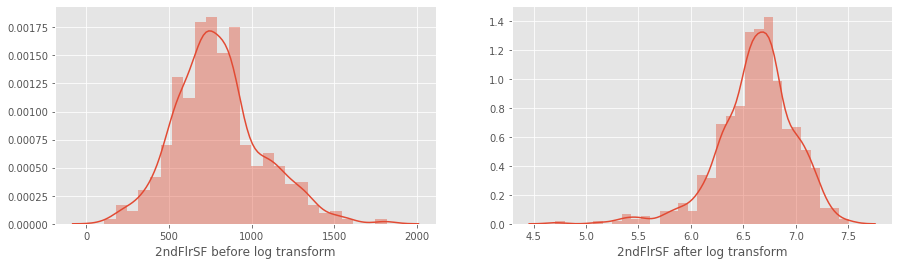

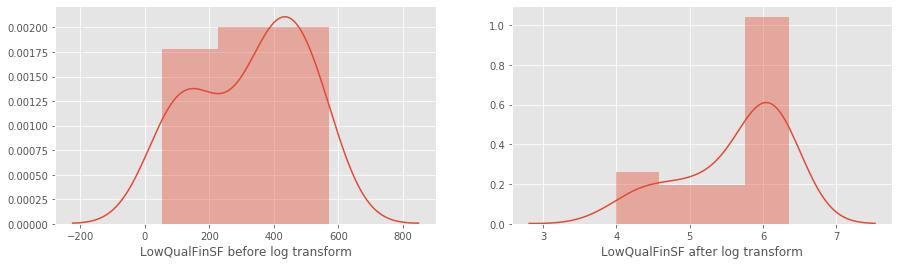

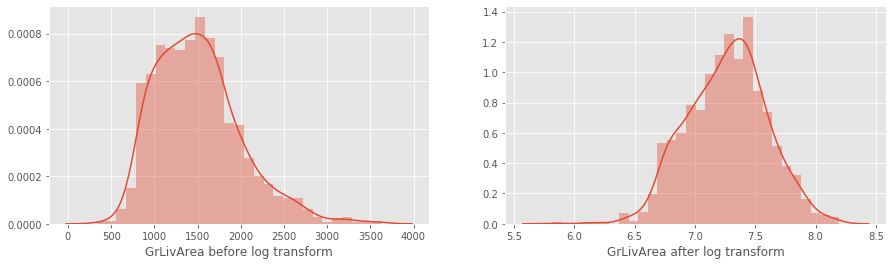

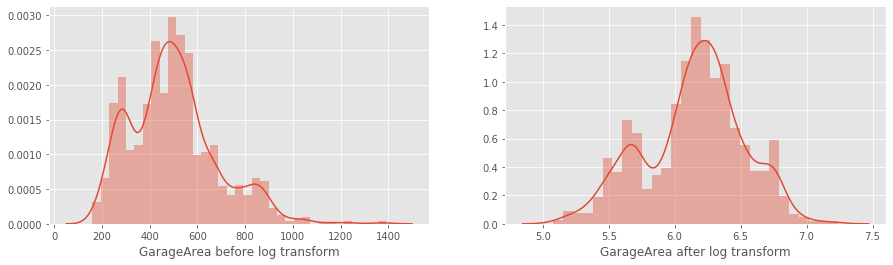

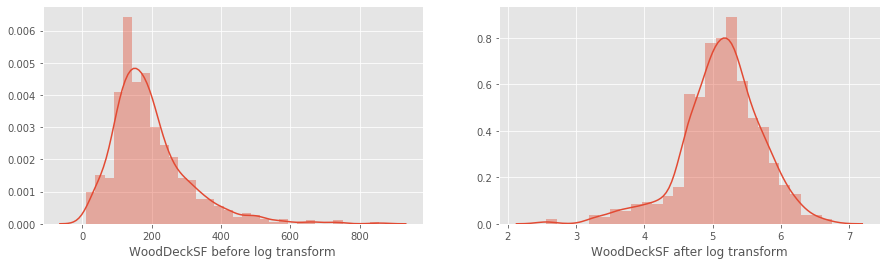

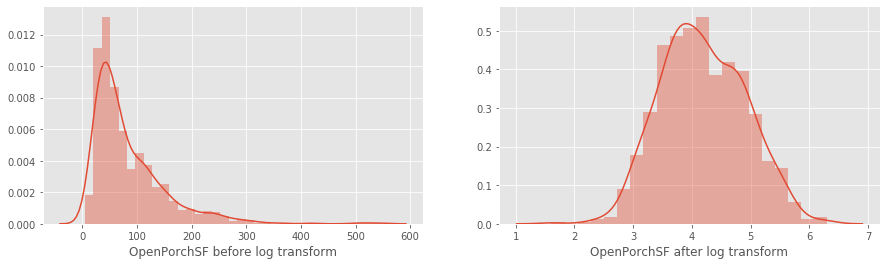

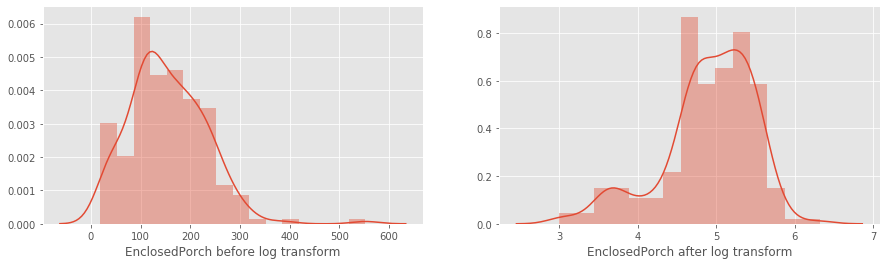

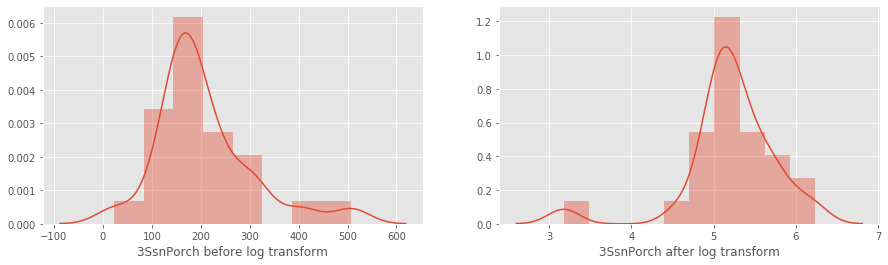

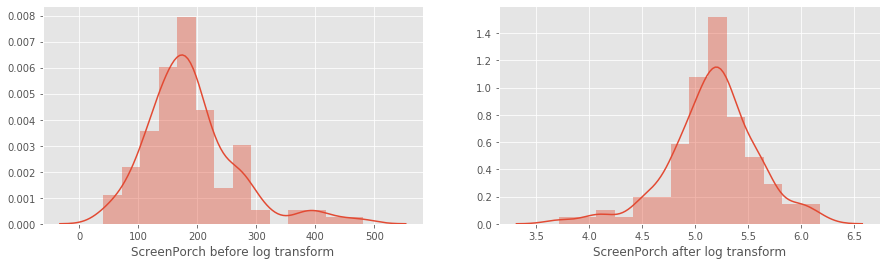

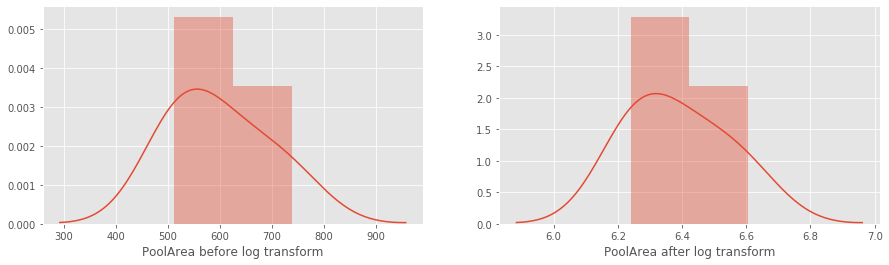

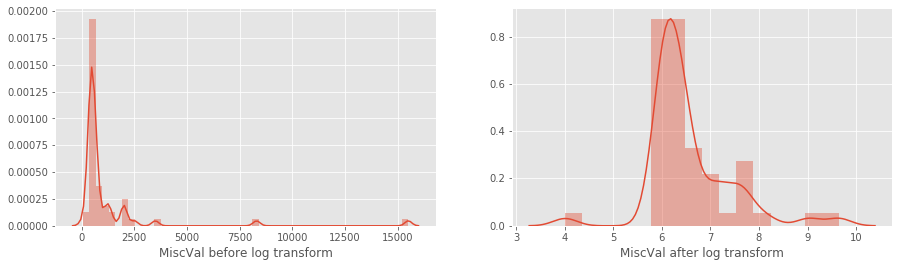

In [85]:
##plot before and after charts
for f in num_continous:
    fig,axes = plt.subplots(1, 2, figsize=(15, 4))
    g = sns.distplot(train[f][train[f] != 0], ax=axes[0])
    g.set(xlabel =f"{f} before log transform")
    g = sns.distplot(train_transformed[f][train_transformed[f] != 0], ax=axes[1])
    g.set(xlabel =f"{f} after log transform")


numerical features are closer to the normal curve post transformation

In [86]:

train_transformed.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

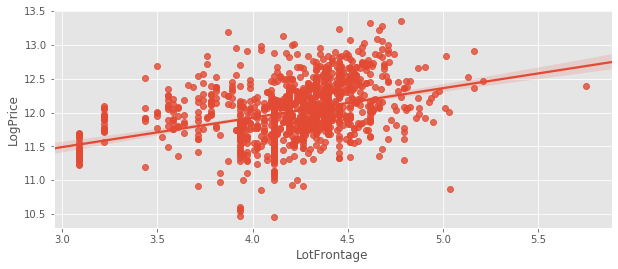

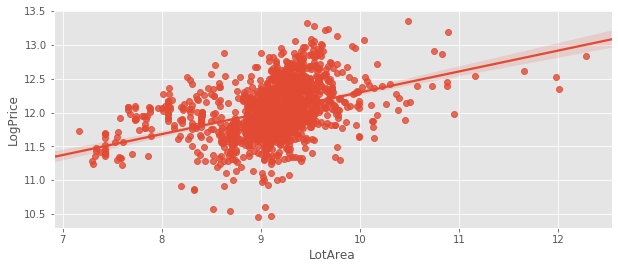

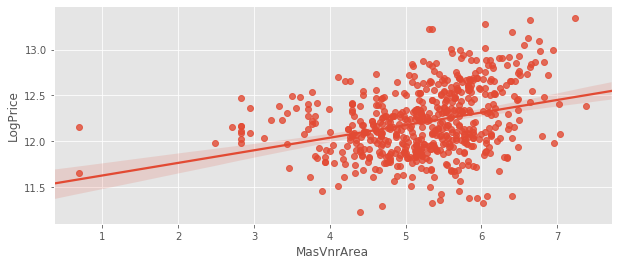

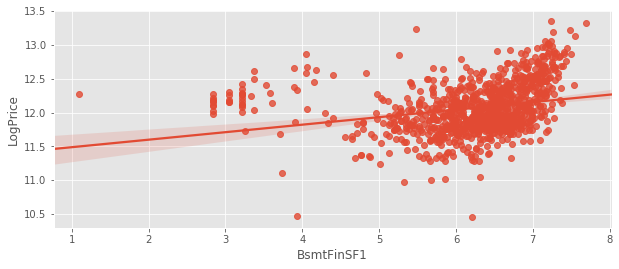

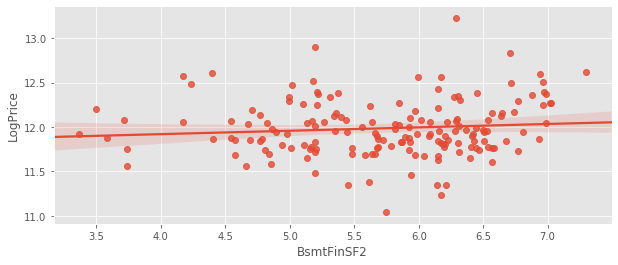

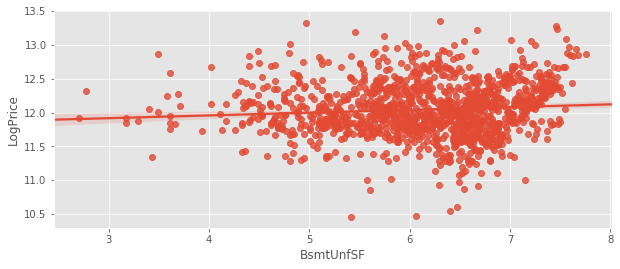

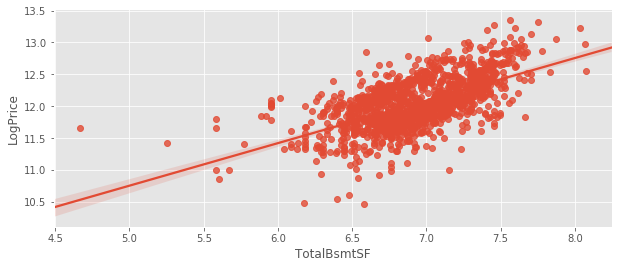

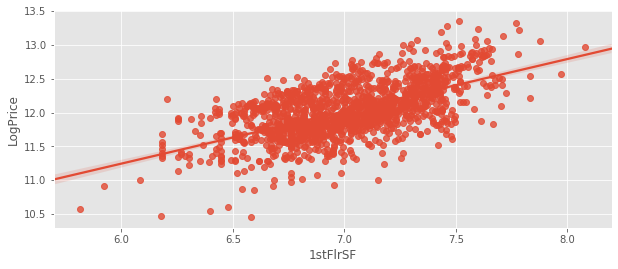

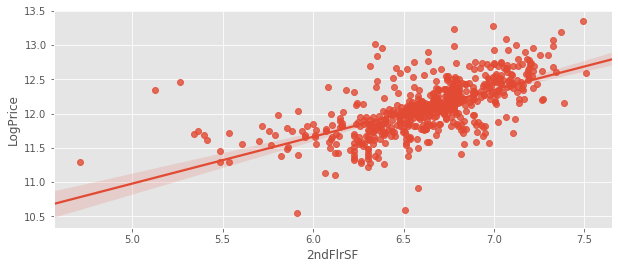

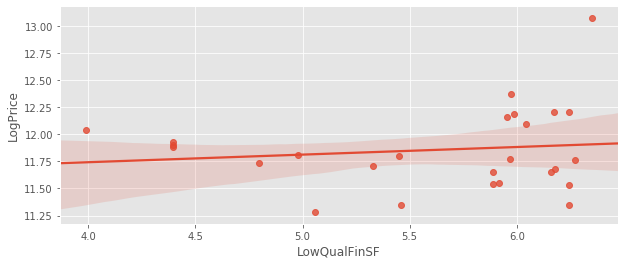

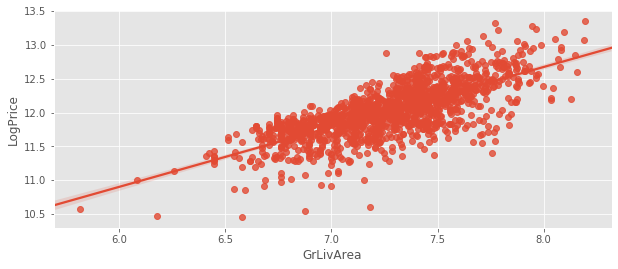

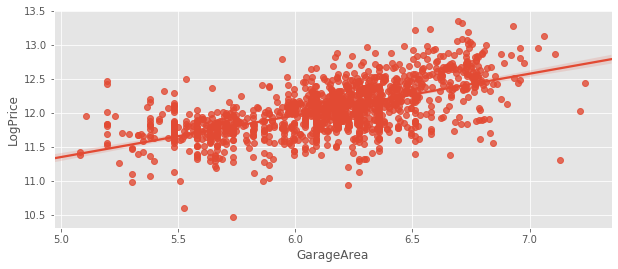

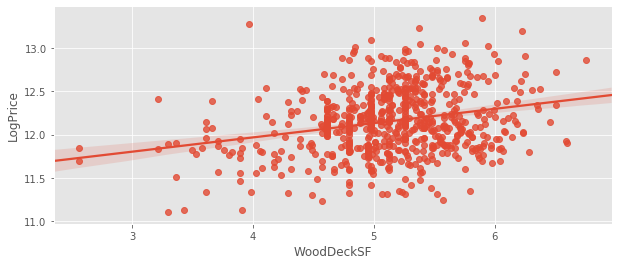

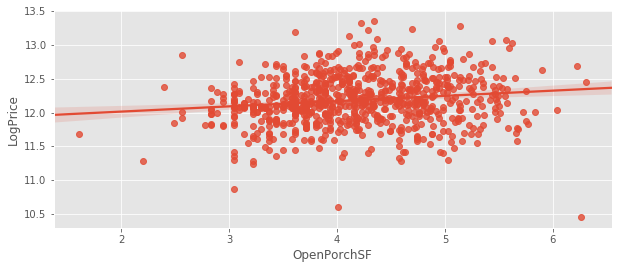

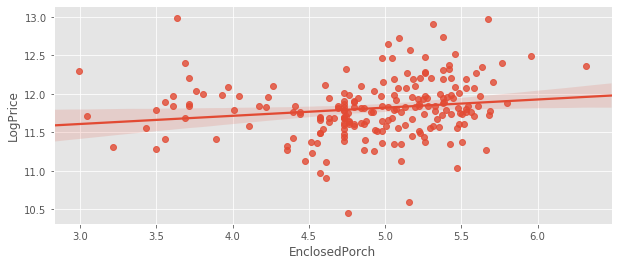

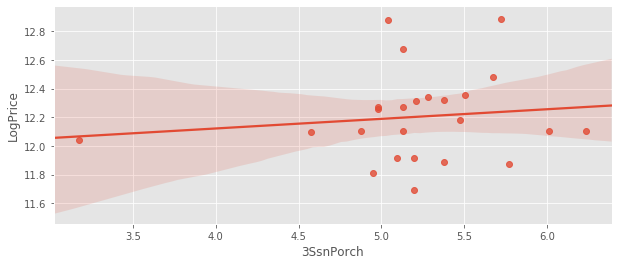

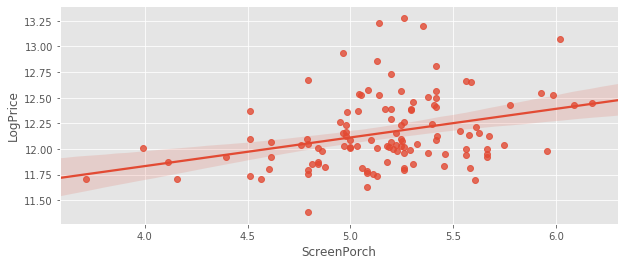

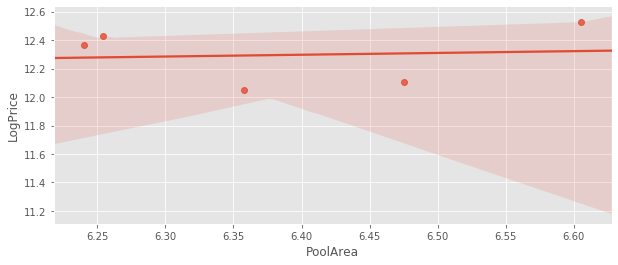

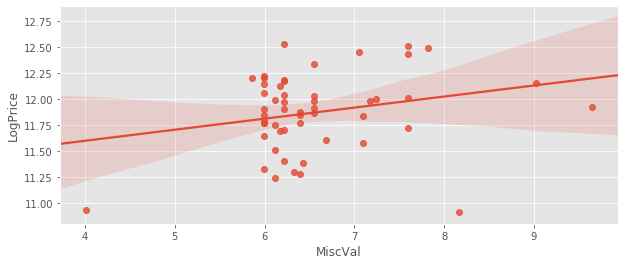

In [87]:
##scatter plot of saleprice vs the log transformed predictors
#num_continous = num_continous.remove('LogPrice')

for f in num_continous:
    fig,axes = plt.subplots(1, 1, figsize=(10, 4))
    g = sns.regplot(train_transformed[f][train_transformed[f]!=0], train['LogPrice'][train_transformed[f]!=0])
    

BsmtFinSF1 might fit better with quadratic.
Strongest linear relationships:
    LotFrontage, LotArea, MasVnrArea,TotalBsmtSF, 1stFlrSF, 2ndFlrSF, GrLivArea, GarageArea, WoodDeckSF

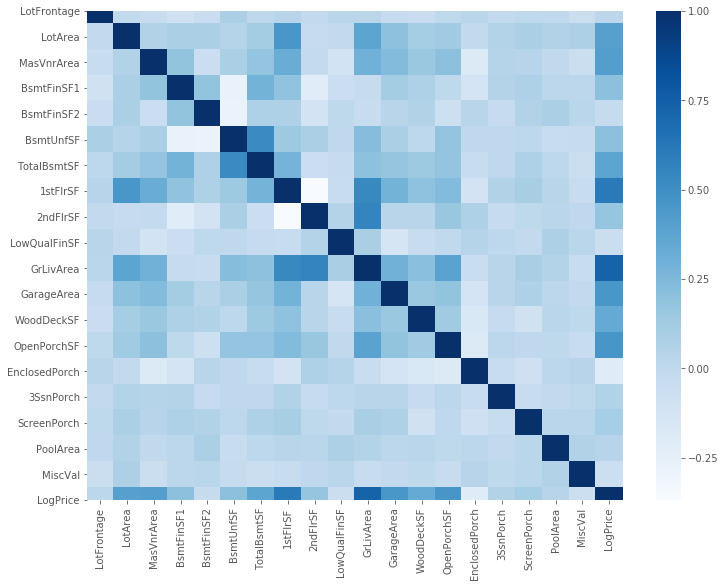

In [88]:
#another way is to look at their correlation to LogPrice
train_transformed['LogPrice'] = train['LogPrice']
corMatrix = train_transformed.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corMatrix, cmap="Blues")

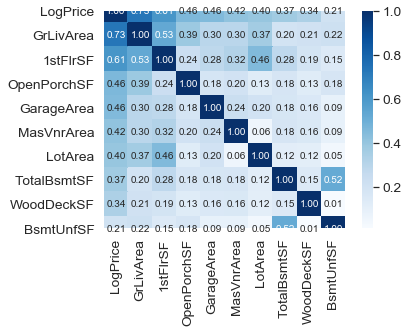

In [89]:
##hone in on top k most correlated
k = 10 #number of variables for heatmap
cols = corMatrix.nlargest(k, 'LogPrice')['LogPrice'].index
cm = np.corrcoef(train_transformed[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cmap="Blues", cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

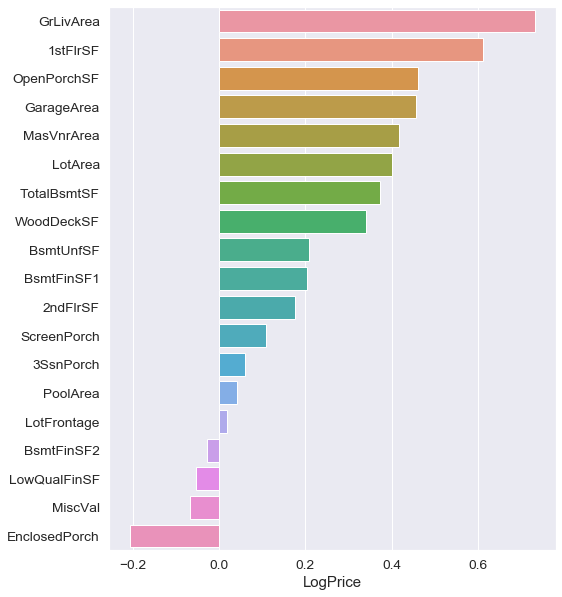

In [90]:
#another view of correlation to saleprice
corr = corMatrix.sort_values('LogPrice', ascending=False)
plt.figure(figsize=(8,10))
sns.barplot( corr.LogPrice[1:], corr.index[1:], orient='h')
plt.show()

In [91]:
if apply_transform:
    for f in num_continous:
        df.loc[:,f] = np.log1p(df[f])

## Standardize

In [92]:
# standardize LogPrice, save the scaler for the inverse transform
if apply_standardization:
    logprice_scaler = StandardScaler().fit(LogPrice[:,np.newaxis])
    Y = logprice_scaler.transform(LogPrice[:,np.newaxis])

In [93]:
# standardize numerical predictors. fit on train, transorm both train and test
if apply_standardization:
    for f in num_continous:
        scaler = StandardScaler().fit(df[f][:len(LogPrice), np.newaxis])
        df[f] = scaler.transform(df[f][:,np.newaxis])

## Feature Generation

In [94]:
##adding some numerical features that are usually looked at together

df['TotalSF'] = df.TotalBsmtSF + df.GrLivArea
df['TotalFloorSF'] = df['1stFlrSF'] + df['2ndFlrSF']
df['TotalPorchSF'] = df.OpenPorchSF + df.EnclosedPorch + df['3SsnPorch'] + df.ScreenPorch

In [95]:
num_continous += ['TotalSF','TotalFloorSF','TotalPorchSF']

# Dummify the nominal values.

In [96]:

df_dummified = pd.get_dummies(df,drop_first=True)

In [97]:
df_dummified.shape

(2915, 248)

# VIF check for multicollinearity

In [98]:
#Rob: added VIF just because... 
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["features"] = df_dummified.columns
vif["VIF"] = [variance_inflation_factor(df_dummified.iloc[:len(LogPrice),:].values, i) for i in range(df_dummified.shape[1])]
vif.sort_values(by=['VIF'], ascending=False)

,features,VIF
178,Exterior2nd_CBlock,inf
86,MSSubClass_90,inf
215,MiscFeature_None,inf
214,GarageType_None,inf
25,1stFlrSF,inf
...,...,...
72,MSSubClass_150,NaN
88,MSZoning_None,NaN
168,Exterior1st_None,NaN
183,Exterior2nd_None,NaN


huge multicollinearity in the feature space

## Features Checkpoint

In [99]:
import time
df_dummified.to_csv(f'data/features_{round(time.time())}.csv', index=False)  #Rob: added index=False

In [100]:
X = df_dummified #Rob: should be changed to read from CSV
X_train = X.iloc[:len(Y), :]
X_test  = X.iloc[len(Y):, :]

In [101]:
X_train.shape, X_test.shape, Y.shape 

((1456, 248), (1459, 248), (1456, 1))

# ============ MODEL ============

## Select cross validation K

In [102]:
import sklearn.model_selection as ms

from sklearn import linear_model


In [103]:
lasso = linear_model.Lasso(alpha=0.001) 
lasso.fit(X_train, Y) 

r2 = lasso.score(X_train, Y)
beta0 = lasso.intercept_

betas = pd.Series(lasso.coef_, index=X_train.columns)
betas = betas[betas>0].sort_values(axis=0, ascending=False)

print(r2)
print(beta0)
print(betas)

0.933566414520627
[-16.28252264]
Neighborhood_Crawfor    0.289487
SaleType_New            0.268082
MSZoning_FV             0.232340
MSZoning_RL             0.211805
Neighborhood_StoneBr    0.187104
                          ...   
LowQualFinSF            0.002123
LandContour_HLS         0.002050
YearRemodAdd            0.001737
Heating_GasW            0.001716
OpenPorchSF             0.000470
Length: 72, dtype: float64


In [104]:
import sklearn.model_selection as ms

In [105]:
lasso = linear_model.Lasso(alpha=0.001) 
scores = ms.cross_val_score(estimator=lasso, X=X_train, y=Y, cv=10)

print('Scores: {}'.format(scores))
print('Score mean: {}'.format(scores.mean()))
print('Score std deviation: {}'.format(scores.std()))

Scores: [0.88905261 0.9374588  0.93153353 0.90968367 0.90861704 0.91842118
 0.90650754 0.93693544 0.92806561 0.91304318]
Score mean: 0.9179318605548328
Score std deviation: 0.0147431323289115


In [106]:
r2_mean = []
r2_se = []
 
kfold = range(5,40,5)    
for i in kfold:
    print(f'Evaluating kfold={i}')
    scores = ms.cross_val_score(estimator=lasso, X=X_train, y=Y, cv=i)
    r2_mean.append(scores.mean())
    r2_se.append(scores.std())

Evaluating kfold=5
Evaluating kfold=10
Evaluating kfold=15
Evaluating kfold=20
Evaluating kfold=25
Evaluating kfold=30
Evaluating kfold=35


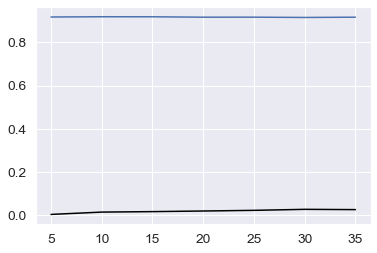

In [107]:
plt.plot(kfold, r2_mean)
plt.plot(kfold, r2_se, color='black')
plt.show()

In [108]:
# CONCLUSION: 
# K=5  is enough, no need for more

In [109]:

# potential filter to select features
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(X_train, Y)
mi /= np.max(mi)

mi = pd.Series(mi, index=X_train.columns)
mi = mi.sort_values(axis=0, ascending=False)

In [110]:
print('Top influential:')
mi[:10]


Top influential:


TotalSF         1.000000
OverallQual     0.877438
TotalFloorSF    0.762400
GrLivArea       0.694070
YearBuilt       0.556892
GarageCars      0.556881
TotalBsmtSF     0.547897
GarageArea      0.545491
ExterQual       0.511173
KitchenQual     0.477413
dtype: float64

## Grid Search

In [111]:
def prices_from_normalized(normalized):
    return np.exp(logprice_scaler.inverse_transform(normalized)).round()

In [112]:
def rmsle(y_true, y_hat):
    return np.sqrt(np.mean((np.log(y_true)-np.log(y_hat))**2))

In [113]:
from sklearn.metrics import mean_squared_error, make_scorer
def rmse(y_true, y_pred):
    return mean_squared_error(logprice_scaler.inverse_transform(y_true), 
                              logprice_scaler.inverse_transform(y_pred), 
                              squared=False)

In [114]:
def visualize_HP(df, HP_xlabel, HP_xvalues):
    f,axes = plt.subplots(1, 2, figsize=(16, 4))

    axes[0].plot(df.r2_train, label='R2 train full') 
    axes[0].plot(df.r2_CV_mean, label='R2 CV mean') 
    axes[0].fill_between(range(len(HP_xvalues)), df.r2_CV_mean-2*df.r2_CV_se, df.r2_CV_mean+2*df.r2_CV_se, color='lightgrey')
    axes[0].set_xticks(range(len(HP_xvalues)))
    axes[0].set_xticklabels(HP_xvalues)
    axes[0].set_title('R2:   train vs. cross-validated')
    axes[0].set_xlabel(HP_xlabel)
    axes[0].legend()

    axes[1].plot(df.rmse_train, label='RMSE train full') 
    axes[1].plot(df.rmse_CV_mean, label='RMSE CV mean') 
    axes[1].fill_between(range(len(HP_xvalues)), df.rmse_CV_mean-2*df.rmse_CV_se, df.rmse_CV_mean+2*df.rmse_CV_se, color='lightgrey')
    axes[1].set_xticks(range(len(HP_xvalues)))    
    axes[1].set_xticklabels(HP_xvalues)
    axes[1].set_title('RMSE (LogPrice):   train vs. cross-validated')
    axes[1].set_xlabel(HP_xlabel)
    axes[1].legend()

    plt.show()


In [115]:
# the generic structure of a report dataframe
# 2 hyperparameters as inputs, 6 standard outputs, 2 optional outputs (such as # of features selected by LASSO)
df_CV = pd.DataFrame(columns=['HP_1','HP_2', 
                              'r2_train', 'r2_CV_mean', 'r2_CV_se', 
                              'rmse_train', 'rmse_CV_mean', 'rmse_CV_se', 
                              'OUT_1', 'OUT_2'])
df_CV

,HP_1,HP_2,r2_train,r2_CV_mean,r2_CV_se,rmse_train,rmse_CV_mean,rmse_CV_se,OUT_1,OUT_2


### LASSO

In [119]:
def scores_lasso(X_train, Y, alpha):
    
    model = linear_model.Lasso(alpha=alpha)
    
    model.fit(X_train, Y)
    feat = len(model.coef_[model.coef_>0])
    
    r2_train = model.score(X_train, Y)
    rmse_train = rmse(model.predict(X_train), Y)
    
    r2_scores = ms.cross_val_score(estimator=model, X=X_train, y=Y, cv=5)
    rmse_scores = ms.cross_val_score(estimator=model, X=X_train, y=Y, cv=5, scoring=make_scorer(rmse))

    return (r2_train, r2_scores.mean(), r2_scores.std(), 
           rmse_train, rmse_scores.mean(), rmse_scores.std(), 
           feat)

In [120]:
tic=time.time()
X_train = pd.get_dummies(df, drop_first=True).iloc[:len(Y), :]

df_lasso = df_CV.copy()
df_lasso.rename(columns={'HP_1': 'alpha', 'OUT_1': 'Features'}, inplace=True)

# general convention: from less powerful to more powerful models
for HP_1 in [0.1, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0]:
    df_lasso.loc[df_lasso.shape[0]] = [HP_1, None] + list(scores_lasso(X_train, Y, HP_1)) + [None]
    print(f'{HP_1} \t{time.time()-tic:.1f} sec')          

TypeError: mean_squared_error() got an unexpected keyword argument 'squared'

In [121]:
# pd.set_option('precision', 4)
df_lasso

,alpha,HP_2,r2_train,r2_CV_mean,r2_CV_se,rmse_train,rmse_CV_mean,rmse_CV_se,Features,OUT_2


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

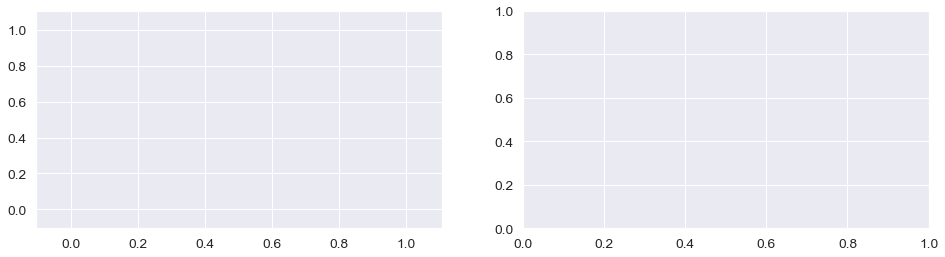

In [122]:
visualize_HP(df_lasso, 'Lasso alpha', list(df_lasso.alpha.values))

### XGBoost

In [123]:
from xgboost import XGBRegressor

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
def scores_xgboost(X_train, Y, n_estimators=3000, subsample=0.5):

    model = XGBRegressor(learning_rate=0.02,   # >>> 0.02
                       n_estimators=n_estimators,   # >>> 3000
                       max_depth=3,          # >>> 3
                       min_child_weight=1,   # another regularization, default 1
                       reg_alpha=0.1,      # L1 reg on weights   >>> 0.1
                       gamma=0,       # min.similarity threshold 
                       subsample=0.5,         # cross-validation capability   >>> 0.5
                       colsample_bytree=0.25,  # % of features used by tree  >>> 0.25
                       objective= 'reg:squarederror',
                       nthread=-1,            # may help on GPU
                       seed=2020,
                       verbosity=0
                       )
    
    model.fit(X_train, Y)
    
    r2_train = model.score(X_train, Y)
    rmse_train = rmse(model.predict(X_train), Y)
    
    r2_scores = ms.cross_val_score(estimator=model, X=X_train, y=Y, cv=5)
    rmse_scores = ms.cross_val_score(estimator=model, X=X_train, y=Y, cv=5, scoring=make_scorer(rmse))

    return (r2_train, r2_scores.mean(), r2_scores.std(), 
           rmse_train, rmse_scores.mean(), rmse_scores.std())

In [ ]:
tic=time.time()
X_train = pd.get_dummies(df, drop_first=True).iloc[:len(Y), :]

df_xgboost = df_CV.copy()
df_xgboost.rename(columns={'HP_1': 'n_estimators', 'HP_2': 'subsample'}, inplace=True)

# general convention: from less powerful to more powerful models
for HP_1 in [2000]:
    for HP_2 in [0.3,0.5,0.7]:
        df_xgboost.loc[df_xgboost.shape[0]] = [HP_1, HP_2] +\
                    list(scores_xgboost(X_train, Y, HP_1, HP_2)) + [None, None]
        print(f'{HP_1} \t{HP_2} \t{time.time()-tic:.1f} sec')

In [ ]:
df_xgboost

In [ ]:
visualize_HP(df_xgboost, 'XGBoost subsample', list(df_xgboost.subsample.values))

In [ ]:
# Best configuration so far
model = XGBRegressor(learning_rate=0.02,   # >>> 0.02
                   n_estimators=3000,   # >>> 3000
                   max_depth=3,          # >>> 3
                   min_child_weight=1,   # another regularization, default 1
                   reg_alpha=0.1,      # L1 reg on weights   >>> 0.1
                   gamma=0,       # min.similarity threshold 
                   subsample=0.5,         # cross-validation capability   >>> 0.5
                   colsample_bytree=0.25,  # % of features used by tree  >>> 0.25
                   objective= 'reg:squarederror',
                   nthread=-1,            # may help on GPU
                   seed=2020,
                   verbosity=0
                   )

model.fit(X_train, Y)
print('done')

In [ ]:
y_hat = model.predict(X_test)
y_hat = prices_from_normalized(y_hat)

# KAGGLE 0.12246

### sklearn Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
def scores_sklearnboost(X_train, Y, n_estimators, subsample):

    model = GradientBoostingRegressor(n_estimators=n_estimators, 
                                      subsample=subsample, 
                                      learning_rate=0.02, 
                                      max_depth = 3)    
    model.fit(X_train, Y)
    
    r2_train = model.score(X_train, Y)
    rmse_train = rmse(model.predict(X_train), Y)
    
    r2_scores = ms.cross_val_score(estimator=model, X=X_train, y=Y, cv=5)
    rmse_scores = ms.cross_val_score(estimator=model, X=X_train, y=Y, cv=5, scoring=make_scorer(rmse))

    return (r2_train, r2_scores.mean(), r2_scores.std(), 
           rmse_train, rmse_scores.mean(), rmse_scores.std())

In [ ]:
tic=time.time()
X_train = pd.get_dummies(df, drop_first=True).iloc[:len(Y), :]

df_sklearnboost = df_CV.copy()
df_sklearnboost.rename(columns={'HP_1': 'n_estimators', 'HP_2': 'subsample'}, inplace=True)

# general convention: from less powerful to more powerful models
for HP_1 in [2000]:
    for HP_2 in [0.3,0.5,0.7]:
        df_sklearnboost.loc[df_sklearnboost.shape[0]] = [HP_1, HP_2] +\
                    list(scores_sklearnboost(X_train, Y, HP_1, HP_2)) + [None, None]
        print(f'{HP_1} \t{HP_2} \t{time.time()-tic:.1f} sec')

In [ ]:
df_sklearnboost

In [ ]:
visualize_HP(df_sklearnboost, 'sklgboost HP', list(df_sklearnboost.subsample.values))

## Feature Permutations

The logical flow is the following:
1. try HP grid search with ALL features included, settle on [locally] optimal HP for each type of model
2. with these HP fixed, perform feature selection/combinations:
  * remove each group one by one (e.g. Lot, or Garage)
  * remove all except 1 feature within each group (e.g. leave the GarageQual, remove everything else)

In [ ]:
def visualize_groups(df, HP_xlabel, HP_xvalues, hline):
    f,ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.plot(df.rmse_train, label='RMSE train full', marker='o', linestyle='')
    ax.plot(df.rmse_CV_mean, label='RMSE CV mean', marker='o', linestyle='', color='k') 
    ax.axhline(hline, label='RMSE ALL features', color='c')
    
    ax.fill_between(range(len(HP_xvalues)), df.rmse_CV_mean-2*df.rmse_CV_se, df.rmse_CV_mean+2*df.rmse_CV_se, color='lightgrey')
    
    ax.set_xticks(range(len(HP_xvalues)))
    ax.set_xticklabels(HP_xvalues)
    
    ax.set_title('RMSE (LogPrice):   train vs. cross-validated')
    ax.set_xlabel(HP_xlabel)
    ax.legend()
    
    plt.xticks(rotation=90)
    plt.show()


In [ ]:
groups = {

    'area': [
        'TotalSF',
        'TotalFloorSF',
        'TotalPorchSF',
        'GrLivArea',
        '1stFlrSF',
        '2ndFlrSF',
        'LowQualFinSF',
    ],

    'other_continuous': [
        'LotFrontage',
        'LotArea',
        'MasVnrArea',
        'PoolArea',
        'MiscVal',
    ],

    'counts': [
        'BsmtFullBath',
        'BsmtHalfBath',
        'FullBath',
        'HalfBath',
        'BedroomAbvGr',
        'KitchenAbvGr',
        'TotRmsAbvGrd',
        'Fireplaces',
        'GarageCars',      
    ],

    'age': [
        'YearBuilt',
        'YearRemodAdd',
        'GarageYrBlt',
    ],

    'quality_and_exterior': [
         'OverallQual', 
         'KitchenQual',        
         'OverallCond',
         'Exterior1st',
         'Exterior2nd',
         'ExterQual',
         'ExterCond',
         'MasVnrType', 
         '_MasVnrArea',
         'RoofStyle',
         'RoofMatl',
    ],

    'basement': [
        'BsmtFinSF1',
        'BsmtFinSF2',
        'BsmtUnfSF',
        'TotalBsmtSF',
        'BsmtQual',
        'BsmtCond',
        'BsmtExposure',
        'BsmtFinType1',
        'BsmtFinType2',
        '_Basement',    
    ],

    'garage': [
         'GarageFinish',
         'GarageQual',
         'GarageCond',
         'GarageType',
         '_Garage',    
    ],

    'porch': [
        '_Porch',    
        'OpenPorchSF',
        'EnclosedPorch',
        '3SsnPorch',
        'ScreenPorch',
    ],

    'other': [
        'GarageArea',
        'WoodDeckSF',
        'Foundation',
        'Electrical',
        'Fence',
        '_Fence',
        'Utilities',
        'Heating', 
        'HeatingQC',
        'CentralAir',
        'FireplaceQu',
        'PoolQC',
        '_Pool',
        '_WoodDeck',
        'MiscFeature',  # mainly shed
        '_MiscFeature',
    ],

    'location': [
        'MSZoning',
        'Neighborhood',
        'Condition1',
        'Condition2',
    ],

    'sale': [            
        'SaleType',
        'SaleCondition',
        '_NormalSale',
        'MoSold',
        'YrSold',
    ],

    'house_type': [
        'MSSubClass',
        'BldgType',
        'HouseStyle',
        'Functional',
        '_Remodeled',
        '_Old',
        '_New',
         '_AfterWW2',    
    ],

    'land': [    
        'LotShape',
        'LandSlope',
        'LandContour',
        'LotConfig',
        'Street',
        'Alley',
        'PavedDrive',
    ],
}

In [ ]:
len(groups)

## А. Drop features -- Grouped by type

In [ ]:
# Get the benchmark CV score for full features with the optimal HP
lasso_best_alpha = 0.001

X_train = pd.get_dummies(df, drop_first=True).iloc[:len(Y), :]
full_features_rmse = scores_lasso(X_train, Y, lasso_best_alpha)[4]
full_features_rmse


In [ ]:
tic=time.time()
df_lasso = df_CV.copy()
df_lasso.rename(columns={'HP_1': 'dropped_group', 'OUT_1': 'Features'}, inplace=True)

for HP_1 in groups.keys():
    
    df_permut = df.drop(groups[HP_1], axis=1)
    
    X_train = pd.get_dummies(df_permut,drop_first=True).iloc[:len(Y), :]
    
    df_lasso.loc[df_lasso.shape[0]] = [HP_1, None] +\
                                      list(scores_lasso(X_train, Y, lasso_best_alpha)) + [None]
    print(f'{HP_1} \t{time.time()-tic:.1f} sec')  

In [ ]:
df_lasso=df_lasso.sort_values(by='rmse_CV_mean', ascending=False, ignore_index=True)
df_lasso

In [ ]:
visualize_groups(df_lasso, 'Dropped Group', df_lasso.dropped_group, full_features_rmse)

In [ ]:
# Conclusion:  porch, garage, land are borderline.   


In [ ]:
# Try dropping all three:

tic=time.time()
df_lasso = df_CV.copy()
df_lasso.rename(columns={'HP_1': 'dropped_group', 'OUT_1': 'Features'}, inplace=True)
    
df_permut = df.drop(groups['porch']+groups['garage']+groups['land'], axis=1)

print(df.shape)
print(df_permut.shape)

X_train = pd.get_dummies(df_permut,drop_first=True).iloc[:len(Y), :]

df_lasso.loc[df_lasso.shape[0]] = ['3_groups_dropped', None] +\
                                    list(scores_lasso(X_train, Y, lasso_best_alpha)) + [None]
print(f'{HP_1} \t{time.time()-tic:.1f} sec')  

In [ ]:
df_lasso

In [ ]:
# 1. Dropping the three groups IMPROVED performance.  Any fourth does not work
# 2. LASSO left only ~60 features out of 95 initial

In [ ]:
# Try additionally dropping newly created Booleans:

tic=time.time()
df_lasso = df_CV.copy()
df_lasso.rename(columns={'HP_1': 'dropped_boolean', 'OUT_1': 'Features'}, inplace=True)
    
df_permut = df.drop(groups['porch']+groups['garage']+groups['land']+new_boolean, axis=1)

X_train = pd.get_dummies(df_permut,drop_first=True).iloc[:len(Y), :]

df_lasso.loc[df_lasso.shape[0]] = ['all_boolean', None] +\
                                    list(scores_lasso(X_train, Y, lasso_best_alpha)) + [None]
print(f'{HP_1} \t{time.time()-tic:.1f} sec')  

In [ ]:
df_lasso

In [ ]:
# The best model (at least for LASSO) is lean:
#     - remove Porch, Garage, Land groups
#     - remove new booleans 

## B. Drop features -- Least influential (correlated)

In [ ]:
X_train = pd.get_dummies(df, drop_first=True).iloc[:len(Y), :]

mi = mutual_info_regression(X_train, Y)
mi /= np.max(mi)

mi = pd.Series(mi, index=X_train.columns)
mi = mi.sort_values(axis=0, ascending=False)

In [ ]:
X_train.shape

In [ ]:
list(mi.index[-5:])

In [ ]:
tic=time.time()
df_lasso = df_CV.copy()
df_lasso.rename(columns={'HP_1': 'dropped_n', 'OUT_1': 'Features'}, inplace=True)

for HP_1 in range(10,200,10):
    
    df_full = pd.get_dummies(df, drop_first=True).iloc[:len(Y), :]
    
    X_train = df_full.drop(list(mi.index[-HP_1:]), axis=1)

#     X_train = pd.get_dummies(df_permut,drop_first=True).iloc[:len(Y), :]
    
    df_lasso.loc[df_lasso.shape[0]] = [HP_1, None] +\
                                      list(scores_lasso(X_train, Y, lasso_best_alpha)) + [None]
    print(f'{HP_1} \t{time.time()-tic:.1f} sec')  

In [ ]:
df_lasso

In [ ]:
# The best score so far:  CUT THE TAIL OF 50

## C. Drop features within groups, especially multicollinear (e.g. 'Area')

In [ ]:
tic=time.time()
df_lasso = df_CV.copy()
df_lasso.rename(columns={'HP_1': 'area', 'OUT_1': 'Features'}, inplace=True)

for HP_1 in groups['area']:
    
    df_permut = df.drop(HP_1, axis=1)
    df_dummified = pd.get_dummies(df_permut,drop_first=True)

    X_train = df_dummified.iloc[:len(Y), :]
    
    df_lasso.loc[df_lasso.shape[0]] = [HP_1, None] + list(scores_lasso(X_train, Y, 0.003)) + [None]
    print(f'{HP_1} \t{time.time()-tic:.1f} sec')  

In [ ]:
df_lasso

In [ ]:
# Any improvements seem to be marginal, LASSO seems to take care of redundancy by itself

# Submissions

In [ ]:
xgboost = XGBRegressor(learning_rate=0.01,   # GridSearch?
                       #n_estimators=3460,
                       max_depth=3,          #  GridSearch
                       min_child_weight=1,   # another regularization, default 1
                       reg_alpha=0.0001,      # L1 reg on weights  - GridSearch
                       gamma=0,       # min.similarity threshold 
                       subsample=0.8,         # cross-validation capability
                       colsample_bytree=0.3,  # ~ about 25%-30% of columns - GridSearch
#                        reg_lambda = 
                       objective= 'reg:squarederror',
                       nthread=-1,            # may help on GPU
                       seed=2020,
                       verbosity=2
                       )


In [ ]:
xgboost.fit(X_train, Y)

In [ ]:
y_hat_train = xgboost.predict(X_train)

In [ ]:
print(rmsle(prices_from_normalized(Y), prices_from_normalized(y_hat_train)))
plt.scatter(prices_from_normalized(Y), prices_from_normalized(y_hat_train))

In [ ]:
y_hat = xgboost.predict(X_test)
y_hat = prices_from_normalized(y_hat)

In [ ]:
submission_df = pd.DataFrame(data={'Id':test.Id, 'SalePrice':y_hat})
submission_df.to_csv(f'./predictions_{round(time.time())}.csv', index=False)

In [ ]:
#Your submission scored 0.25310


### Lasso

In [ ]:
mi_tail=50

#df_full = pd.get_dummies(df, drop_first=True)
df_trimmed = pd.get_dummies(df, drop_first=True).drop(list(mi.index[-mi_tail:]), axis=1)

X_train = df_trimmed.iloc[:len(Y), :]
X_test = df_trimmed.iloc[len(Y):, :]

In [ ]:
model = linear_model.Lasso(alpha=lasso_best_alpha) 
model.fit(X_train, Y) 

In [ ]:
y_hat = model.predict(X_test)
y_hat = logprice_scaler.inverse_transform(y_hat)
y_hat = np.exp(y_hat).round()
y_hat

In [ ]:
submission_df = pd.DataFrame(data={'Id':test.Id, 'SalePrice':y_hat})
submission_df.to_csv(f'./predictions_{round(time.time())}.csv', index=False)

In [ ]:
y_hat_train = model.predict(X_train)
# y_hat_train = prices_from_normalized(y_hat_train)

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(SalePrice, prices_from_normalized(y_hat_train))
plt.plot( (min(SalePrice), max(SalePrice)), (min(SalePrice), max(SalePrice)),color='r')
plt.show()

In [ ]:
# Your submission scored 0.12085, which is an improvement of your previous score of 0.12101. 